In [3]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


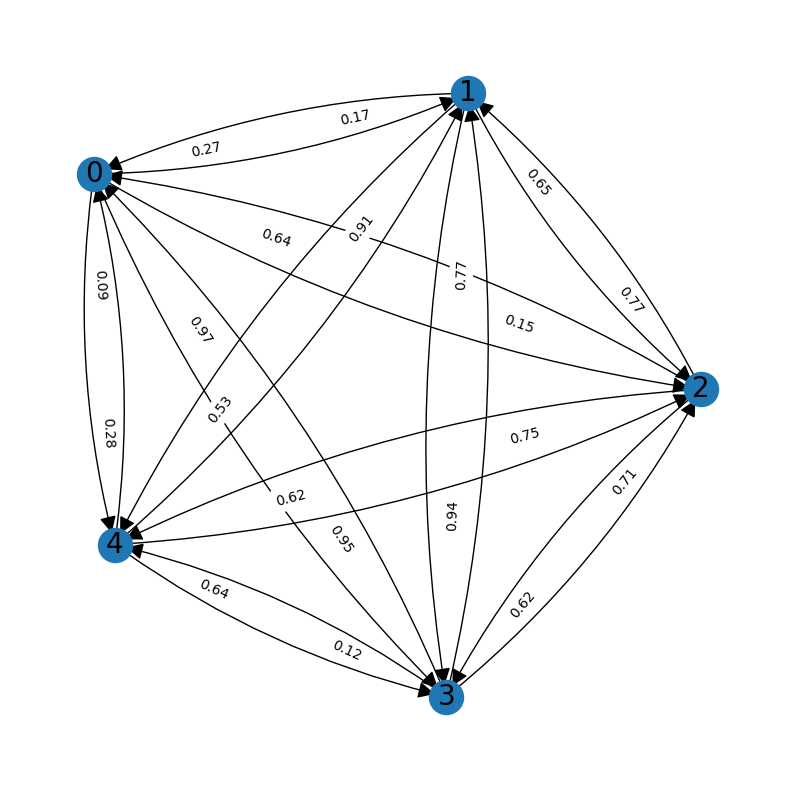

In [11]:
from Simulation import *
from Environment import *

click_probabilities = generate_click_probabilities(fully_connected=True)
observations_probabilities = generate_observation_probabilities(click_probabilities=click_probabilities)

concentration_params = [100] + [70] * NUM_OF_PRODUCTS
alpha_users = np.random.dirichlet(alpha= concentration_params, size = 1)

product_prices, users_reservation_prices = generate_prices(product_range=100, users_range=100)
tot_num_users = np.random.normal(loc=1000, scale=50)

env = Environment(users_reservation_prices = users_reservation_prices,
                    click_probabilities = click_probabilities,
                    observations_probabilities = observations_probabilities,
                    tot_num_users = tot_num_users)

Network.print_graph(G=env.network.G)

In [12]:
nodes_activation_probabilities = env.get_nodes_activation_probabilities(product_prices=product_prices)

In [13]:
B_cap = 100
budgets = np.linspace(start = 0, stop = B_cap, num = 11, endpoint = True)

In [14]:
from Ecommerce3 import *

In [18]:
ecomm3_ts = Ecommerce3_TS(B_cap = B_cap, budgets = budgets, product_prices = product_prices, tot_num_users = tot_num_users)
ecomm3_ucb = Ecommerce3_UCB(B_cap = B_cap, budgets = budgets, product_prices = product_prices, tot_num_users = tot_num_users)

In [ ]:
from Environment import *
from Ecommerce3 import *

for _ in range(100):
    # print('------Thompson Sampling--------')
    # arms_values = ecomm3_ts.pull_arm(nodes_activation_probabilities)
    # print(arms_values)
    # reward = env.round_step3(pulled_arm=arms_values)
    # ecomm3_ts.update(pulled_arm = arms_values, reward = reward)

    print('------UCB--------')
    arms_values = ecomm3_ucb.pull_arm(nodes_activation_probabilities=nodes_activation_probabilities)
    print(arms_values)
    reward = env.round_step3(pulled_arm=arms_values)
    ecomm3_ucb.update(pulled_arm = arms_values, reward = reward)

In [20]:
ecomm3_ts.b

AttributeError: 'Ecommerce3_TS' object has no attribute 'b'

In [21]:
from Ecommerce5 import *

In [22]:
Ecommerce5.run_experiments(
    20,
    10,
    users_reservation_prices,
    click_probabilities,
    observations_probabilities,
    B_cap,
    budgets,
    product_prices,
    tot_num_users,
)


KeyboardInterrupt: 

In [86]:
ecomm5_gpts = Ecommerce5_GPTS(B_cap = B_cap, budgets = budgets, product_prices = product_prices, tot_num_users = tot_num_users)
ecomm5_ucb = Ecommerce5_UCB(B_cap = B_cap, budgets = budgets, product_prices = product_prices, tot_num_users = tot_num_users)